In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
#PROBLEM FORMULATION
#The problem is supervised text classification problem, and our goal is to investigate which supervised machine learning 
#methods are best suited to solve it.
#Given a new complaint comes in, we want to assign it to one of 12 categories.

In [49]:
#PART 01 :
#DATA EXPLORATION 
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Consumer_Complaints.csv')
#remove all column except input and output 
col = ['Product', 'Consumer Complaint']
df= df[col]
#remove null review comments 
df= df[pd.notnull(df['Consumer Complaint'])]
#rename the column from Consumer Complaint to Consumer_complaint
df.columns=['Product', 'Consumer_complaint']
#factorize the product and rename with categoryid 
df['category_id'] = df['Product'].factorize()[0]
#remove duplicates 
#remove product id 
df =df.drop(df.loc[:,['Product']], axis =1 )
df=df.drop_duplicates()

df.head()

,Consumer_complaint,category_id
1,I have outdated information on my credit repor...,0
2,I purchased a new car on XXXX XXXX. The car de...,1
7,An account on my credit report has a mistaken ...,0
12,This company refuses to provide me verificatio...,2
16,This complaint is in regards to Square Two Fin...,2


In [50]:
df['category_id'].value_counts()

2     518
3     407
0     392
4     270
6     185
7     145
1     108
9      26
8      22
10     18
12      9
5       4
13      2
11      2
15      1
14      1
Name: category_id, dtype: int64

In [51]:
#DATA CLEANING 
import re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
def clean_text(df):
    all_reviews = list()
    lines = df["Consumer_complaint"].values.tolist()
    for text in lines:
        text = text.lower()
        text = re.sub('[^a-zA-Z]', ' ', text)
        text = text.replace('x', '')
        #remove single character 
        text = re.sub('\s\w\s',' ',text)
        words=nltk.word_tokenize(text)
        stop_words= set(stopwords.words('english'))
        stop_words.discard("not")
        words_without_stop_words=[word for word in words if word not in stop_words]
        #words=[lemmatizer.lemmatize(word) for word in words_without_stop_words ]
        words=[ps.stem(word) for word in words_without_stop_words ]
        words = ' '.join(words)
        all_reviews.append(words)
    return all_reviews

all_complaint = clean_text(df)
all_complaint[0:20]

['outdat inform credit report previous disput yet remov inform seven year old not meet credit report requir',
 'purchas new car car dealer call citizen bank get day payoff loan good till dealer sent check net day balanc checkbook notic citizen bank taken automat payment check account bank call citizen state not close loan state not receiv check told not believ check took long arriv told check issu amount overpaid deduct addit interest today call citizen bank talk supervisor name receiv letter loan paid full date refund check includ state hold payment busi day loan satisfi check would mail wed question delay post dealer payment first state sometim take busi day post said not receiv check till told not believ ask money state hold payment busi day ask simpli said polici ask would receiv interest money state believ citizen bank deliber delay post payment return consum money make addit interest bank not illeg hurt consum not ethic amount money lost minim thousand car loan month addit intere

In [53]:
#FIRST We will make all text data into numrical and of same length 
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

In [54]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences 
#Word Embedding is a representation of text where words that have the same meaning have a similar representation.Embedding layers 
#hrlps to represnts text in vector format 
#pad sequences to make vector of equal length if vector is not that much length then 0s will be added 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.layers import Dense 
import gensim
import os
from tensorflow.python.keras.preprocessing.text import Tokenizer

In [55]:
#number of words in each review/ happymoments/sentence=55
validation_split = 0.2
max_length = 80
#tokenize te sentences and represent them in numbers other way is to todo one hot 
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(all_complaint)
sequences = tokenizer_obj.texts_to_sequences(all_complaint)
sequences

[[1761, 11, 3, 5, 570, 43, 237, 65, 11, 1152, 23, 369, 1, 571, 3, 5, 131],
 [107,
  77,
  198,
  198,
  1439,
  6,
  649,
  8,
  20,
  30,
  520,
  7,
  270,
  1326,
  1439,
  33,
  27,
  280,
  30,
  53,
  3794,
  103,
  649,
  8,
  304,
  563,
  4,
  27,
  2,
  8,
  6,
  649,
  28,
  1,
  61,
  7,
  28,
  1,
  10,
  27,
  13,
  1,
  185,
  27,
  191,
  381,
  915,
  13,
  27,
  68,
  40,
  2366,
  742,
  160,
  63,
  199,
  6,
  649,
  8,
  256,
  252,
  57,
  10,
  19,
  7,
  37,
  132,
  52,
  219,
  27,
  159,
  28,
  257,
  4,
  146,
  30,
  7,
  726,
  27,
  9,
  79,
  3043,
  212,
  542,
  332,
  1439,
  4,
  116,
  28,
  1043,
  82,
  146,
  30,
  332,
  41,
  1,
  10,
  27,
  1326,
  13,
  1,
  185,
  21,
  42,
  28,
  257,
  4,
  146,
  30,
  21,
  564,
  41,
  453,
  21,
  9,
  10,
  63,
  42,
  28,
  185,
  649,
  8,
  1327,
  542,
  332,
  4,
  119,
  117,
  42,
  38,
  160,
  63,
  8,
  1,
  344,
  991,
  117,
  1,
  1440,
  40,
  42,
  370,
  2130,
  992,
  198,
  7,
  

In [56]:
word_index = tokenizer_obj.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab_size - '+str(vocab_size))

unique tokens - 5977
vocab_size - 5978


In [57]:
#get first 10 elements word_index
dict_items = word_index.items()
first_ten = list(dict_items)[:10]
print(first_ten)

[('not', 1), ('account', 2), ('credit', 3), ('payment', 4), ('report', 5), ('call', 6), ('loan', 7), ('bank', 8), ('would', 9), ('receiv', 10)]


In [58]:
#do padding 
lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
lines_pad

array([[1761,   11,    3, ...,    0,    0,    0],
       [1439,    4,  116, ...,   23,  470,  230],
       [  79,   28,  241, ...,  612,  471,   19],
       ...,
       [2576,  832,  115, ...,  863,  439,  607],
       [ 872,   18,   37, ...,    0,    0,    0],
       [ 166,   91,  380, ...,    0,    0,    0]], dtype=int32)

In [59]:
print("Now we have no of complaints as features :",len(lines_pad))
print("Number of target label", len(df['category_id']))

Now we have no of complaints as features : 2110
Number of target label 2110


In [60]:
#deine X and y 
X=lines_pad
y=pd.get_dummies(df['category_id']).values

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print('Shape of X_train_pad:', X_train.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (1688, 80)
Shape of y_train: (1688, 16)
Shape of X_test_pad: (422, 80)
Shape of y_test: (422, 16)


In [62]:
#LSTM Model creation
embedding_vector_features=100 # i,e number of column of embedding matrix 
# vocab_size NO of words present in the document after one hot 
model= Sequential()
model.add(Embedding(vocab_size,embedding_vector_features,input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(16, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 80, 100)           597800    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1616      
Total params: 679,816
Trainable params: 679,816
Non-trainable params: 0
_________________________________________________________________
None


In [63]:
history_LSTM = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=30,batch_size=16)

Epoch 1/30
106/106 [==============================] - 47s 442ms/step - loss: 2.1116 - accuracy: 0.2405 - val_loss: 1.9408 - val_accuracy: 0.3033
Epoch 2/30
106/106 [==============================] - 47s 439ms/step - loss: 1.9598 - accuracy: 0.2790 - val_loss: 1.9699 - val_accuracy: 0.2701
Epoch 3/30
106/106 [==============================] - 47s 441ms/step - loss: 1.8783 - accuracy: 0.3122 - val_loss: 2.3841 - val_accuracy: 0.3436
Epoch 4/30
106/106 [==============================] - 47s 444ms/step - loss: 1.8275 - accuracy: 0.3371 - val_loss: 1.7978 - val_accuracy: 0.3602
Epoch 5/30
106/106 [==============================] - 47s 439ms/step - loss: 1.7020 - accuracy: 0.3525 - val_loss: 1.7763 - val_accuracy: 0.3531
Epoch 6/30
106/106 [==============================] - 47s 448ms/step - loss: 1.6153 - accuracy: 0.4177 - val_loss: 1.6822 - val_accuracy: 0.3673
Epoch 7/30
106/106 [==============================] - 47s 441ms/step - loss: 1.5018 - accuracy: 0.4396 - val_loss: 1.7133 - val_ac

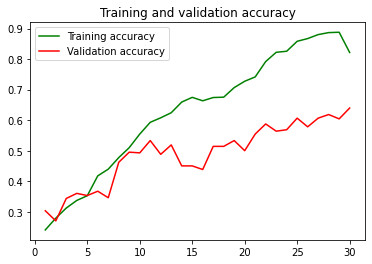

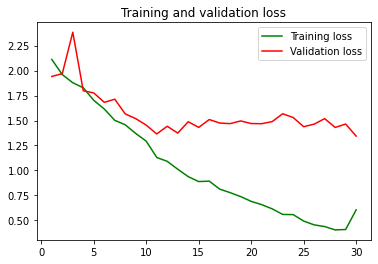

In [64]:
# Plot results
import matplotlib.pyplot as plt

acc = history_LSTM.history['accuracy']
val_acc = history_LSTM.history['val_accuracy']
loss = history_LSTM.history['loss']
val_loss = history_LSTM.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [65]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

14/14 [==============================] - 1s 52ms/step - loss: 1.3437 - accuracy: 0.6398
Test set
  Loss: 1.344
  Accuracy: 0.640


In [66]:
#new complaint 
import numpy as np
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer_obj.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

[[1.35322986e-03 2.86555756e-02 8.39240476e-02 2.90434784e-03
  7.33943939e-01 9.97429062e-03 3.97967435e-02 1.16404705e-02
  3.37983295e-02 1.80855077e-02 2.11241804e-02 3.34018166e-03
  8.93554743e-03 2.39300542e-03 5.34068058e-05 7.72656495e-05]] Student loan


In [66]:
#SAMETHING WE WILL DO WITH WORD 2 VEC PRE TRAINED MODEL 